In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.under_sampling import RandomUnderSampler, NeighbourhoodCleaningRule
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GroupKFold,GroupShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier


In [2]:
fbk_dataset = pd.read_csv('../data/processed/fbk_processed.csv')
fbk_dataset['individual_stress_tolerance'] = fbk_dataset['stress_tolerance']
fbk_dataset['ambient_weekday'] = fbk_dataset['date'].astype('datetime64[ns]').dt.weekday
del fbk_dataset['stress_tolerance']
sl_dataset = pd.read_csv('../data/processed/sl_processed.csv')
sl_dataset['individual_stress_tolerance'] = sl_dataset['stress_tolerance']
sl_dataset['ambient_weekday'] = sl_dataset['date'].astype('datetime64[ns]').dt.weekday
del sl_dataset['stress_tolerance']

In [3]:
'''
'fbk_old' : {
    'dataframe' : fbk_old_dataset,
    'features' : {
        'organizational' : ['workload', 'voice'],
        'individual' : ['sleep'],
        'ambient' : ['ambient_weekday']
    }
},
'''

data = {
        'fbk' : {
            'dataframe' : fbk_dataset,
            'features' : {
                'organizational' : ['organizational_workload', 'organizational_socialinteraction'],
                'individual' : ['individual_sleep', 'individual_stress_tolerance'],
                'ambient' : ['ambient_temperature', 'ambient_precipitation', 'ambient_humidity', 'ambient_cloudcover', 'ambient_weekday']
            }
        },
        'sl': {
            'dataframe' : sl_dataset,
            'features' : {
                'organizational' : ['organizational_workload', 'organizational_socialinteraction'],
                'individual' : ['individual_sleep', 'individual_stress_tolerance'],
                'ambient' : ['ambient_temperature', 'ambient_precipitation', 'ambient_humidity', 'ambient_cloudcover', 'ambient_weekday']
            }
        },
}

In [4]:
## create additional features
def create_features(dataset_name, window_size, feature_nature):   
    dataframe = data[dataset_name]['dataframe'].copy()
    
    existing_features = sum(data[dataset_name]['features'].values(), []) + ['stress', 'user', 'date']
    # remove all columns not in existing_features
    dataframe = dataframe[dataframe.columns.intersection(existing_features)]

    features_without_metrics = ['ambient_weekday', 'individual_stress_tolerance']

    if window_size == 1:
        dataframe['individual_prev_stress'] = dataframe.groupby('user')['stress'].shift(1)
        dataframe.dropna(inplace=True)
        return dataframe

    for feature in sum(data[dataset_name]['features'].values(), []):
        if feature in features_without_metrics:
            continue
        
        f_sum = 0
        f_values = []

        for i in range(0, window_size):
            f_prev = dataframe.groupby('user')[feature].shift(i)
            f_sum += f_prev
            f_values.append(f_prev)

            if feature_nature == '1st-order':
                dataframe['{}_prev_{}'.format(feature, i)] = f_prev
        
        if feature_nature == '2nd-order':
            dataframe['{}_avg_{}'.format(feature, window_size)] = f_sum / window_size
            dataframe['{}_std_{}'.format(feature, window_size)] = np.std(f_values, axis=0)
            dataframe['{}_max_{}'.format(feature, window_size)] = np.max(f_values, axis=0)
            dataframe['{}_min_{}'.format(feature, window_size)] = np.min(f_values, axis=0)
            dataframe['{}_delta_{}'.format(feature, window_size)] = sum([f_values[n-1]-f_values[n] for n in range(1, len(f_values))])
            dataframe['{}_var_{}'.format(feature, window_size)] = np.var(f_values, axis=0)
    
    stress_sum = 0
    stress_values = []

    if window_size > 2:
        for i in range(1, window_size):
            stress_prev = dataframe.groupby('user')['stress'].shift(i)
            stress_sum += stress_prev
            stress_values.append(stress_prev)

            if feature_nature == '1st-order':
                dataframe['individual_stress_prev_{}'.format(i)] = stress_prev
            elif feature_nature == '2nd-order':
                dataframe['individual_{}_avg_{}'.format('stress', window_size)] = stress_sum / (window_size-1)
                dataframe['individual_{}_std_{}'.format('stress', window_size)] = np.std(stress_values, axis=0)
                dataframe['individual_{}_max_{}'.format('stress', window_size)] = np.max(stress_values, axis=0)
                dataframe['individual_{}_min_{}'.format('stress', window_size)] = np.min(stress_values, axis=0)
                dataframe['individual_{}_delta_{}'.format('stress', window_size)] = sum([stress_values[n-1]-stress_values[n] for n in range(1, len(stress_values))])
                dataframe['individual_{}_var_{}'.format('stress', window_size)] = np.var(stress_values, axis=0)
    
    if feature_nature != '1st-order':
        dataframe['individual_stress_prev'] = dataframe.groupby('user')['stress'].shift(1)
    dataframe.dropna(inplace=True)
    return dataframe

def select_classifier(clf_name):
    if clf_name == 'LogR':
        return LogisticRegression(max_iter=1500000, random_state=24091993)
    elif clf_name == 'LinSVM':
        return LinearSVC(max_iter=1500000, random_state=24091993)
    elif clf_name == 'DT':
        return DecisionTreeClassifier(random_state=24091993)
    elif clf_name == 'RF':
        return RandomForestClassifier(random_state=24091993)
    elif clf_name == 'MLP':
        return MLPClassifier(max_iter=1500000, random_state=24091993)
    elif clf_name == 'xGB':
        return xgb.XGBClassifier(seed=24091993, objective='multi:softmax', num_class=3)
    

def select_params(clf_name):
    if clf_name == 'LogR':
        return {'C': np.logspace(-3,2, num=10),}
    elif clf_name == 'LinSVM':
        return {'C': np.logspace(-3,2, num=10), }
    elif clf_name == 'DT':
        return {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    elif clf_name == 'xGB':
        return {
            'max_depth': range (2, 10, 1),
            'n_estimators': range(60, 220, 40),
            'learning_rate': [0.1, 0.01, 0.05]
        }
    elif clf_name == 'MLP':
        return {
            'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
    elif clf_name == 'RF':
        return {
            'max_depth': range (2, 10, 1),
            'n_estimators': range(60, 220, 40),
            'criterion' :['gini', 'entropy'],
            'min_samples_leaf' : range(1, 20, 2),
        }

### 1st order model

In [12]:
# create dataframe to store results
results = pd.DataFrame(columns=['dataset', 'feature_nature', 'feature_category', 'feature_names', 'feature_importances', 'window_size', 'clf_name', 'clf_params', 'accuracy', 'f1', 'precision', 'recall'])

In [13]:
for dataset_name in ['fbk', 'sl']:
    for feature_nature in ['1st-order']:
        for feature_category in ['individual', 'organizational', 'ambient', ['individual', 'organizational'], ['individual', 'ambient'], ['organizational', 'ambient'], ['individual', 'organizational', 'ambient']]:
            available_windows = [1,2,3,4,5,6,7,8,9,10]
            for window_size in available_windows:
                for clf_name in ['RF', 'xGB']:
                    dataframe = create_features(dataset_name, window_size, feature_nature).reset_index()
                    
                    if feature_category == 'individual':
                        # remove those features from the others categories
                        organizational_features = [col for col in dataframe.columns if 'organizational' in col]
                        ambient_features = [col for col in dataframe.columns if 'ambient' in col]
                        dataframe = dataframe.drop(organizational_features + ambient_features, axis=1)
                    elif feature_category == 'organizational':
                        # remove those features from the others categories
                        individual_features = [col for col in dataframe.columns if 'individual' in col]
                        ambient_features = [col for col in dataframe.columns if 'ambient' in col]
                        dataframe = dataframe.drop(individual_features + ambient_features, axis=1)
                    elif feature_category == 'ambient':
                        # remove those features from the others categories
                        individual_features = [col for col in dataframe.columns if 'individual' in col]
                        organizational_features = [col for col in dataframe.columns if 'organizational' in col]
                        dataframe = dataframe.drop(individual_features + organizational_features, axis=1)
                    elif feature_category == ['individual', 'organizational']:
                        # remove those features from the others categories
                        ambient_features = [col for col in dataframe.columns if 'ambient' in col]
                        dataframe = dataframe.drop(ambient_features, axis=1)
                    elif feature_category == ['individual', 'ambient']:
                        # remove those features from the others categories
                        organizational_features = [col for col in dataframe.columns if 'organizational' in col]
                        dataframe = dataframe.drop(organizational_features, axis=1)
                    elif feature_category == ['organizational', 'ambient']:
                        # remove those features from the others categories
                        individual_features = [col for col in dataframe.columns if 'individual' in col]
                        dataframe = dataframe.drop(individual_features, axis=1)
                    elif feature_category != ['individual', 'organizational', 'ambient']:
                        pass

                    clf = select_classifier(clf_name)
                    params = select_params(clf_name)
                    seed=24091993
                    np.random.seed(seed)

                    X = dataframe.drop(['user', 'stress', 'date', 'index'], axis=1)                    

                    X = X.reindex(sorted(X.columns), axis=1)
                    #X['randNumCol'] = np.random.randint(1, 6, X.shape[0])
                    

                    y = dataframe['stress']
                    le = LabelEncoder()
                    y = le.fit_transform(y)

                    scaler = MinMaxScaler()
                    X = scaler.fit_transform(X)

                    undersample = NeighbourhoodCleaningRule(sampling_strategy='not minority', n_jobs=-1)
                    X, y = undersample.fit_resample(X, y)

                    groups = dataframe.iloc[undersample.sample_indices_]['user'].values

                    # cv = RepeatedStratifiedKFold(n_splits=5, random_state=seed, shuffle=True, n_repeats=3)
                    cv = GroupKFold(n_splits=5)
                    
                    rfe = RFECV(estimator=clf, step=1, cv=cv, scoring='f1_weighted', n_jobs=-1)
                    X = rfe.fit(X, y, groups=groups).transform(X)
                    
                    # get selected features
                    selected_features = dataframe.drop(['user', 'stress', 'date', 'index'], axis=1).columns[rfe.support_]
                    
                    # grid_search = GridSearchCV(clf, params, cv=cv, scoring='f1_weighted', n_jobs=-1)
                    #grid_search = RandomizedSearchCV(clf, params, cv=cv, scoring=['accuracy', 'precision_weighted', 'f1_weighted', 'recall_weighted'], n_jobs=-1, random_state=seed, refit='f1_weighted')
                    clf = select_classifier(clf_name)

                    cross_val_scores = cross_validate(clf, X, y, cv=cv, groups=groups, scoring=['accuracy', 'precision_weighted', 'f1_weighted', 'recall_weighted'], n_jobs=-1)
                    
                    results = results.append({
                        'dataset': dataset_name,
                        'feature_nature': feature_nature,
                        'feature_category': feature_category,
                        'feature_names': selected_features,
                        'feature_importances': '',
                        'window_size': window_size,
                        'clf_name': clf_name,
                        'clf_params': '',
                        'accuracy': cross_val_scores['test_accuracy'].mean(),
                        'f1': cross_val_scores['test_f1_weighted'].mean(),
                        'precision': cross_val_scores['test_precision_weighted'].mean(),
                        'recall': cross_val_scores['test_recall_weighted'].mean(),
                    }, ignore_index=True)
                    

/tmp/ipykernel_4693/4033699878.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_4693/4033699878.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_4693/4033699878.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_4693/4033699878.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
/tmp/ipykernel_4693/4033699878.py:77: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({


In [7]:
# create dataframe to store results
results = pd.DataFrame(columns=['dataset', 'feature_nature', 'feature_category', 'feature_names', 'feature_importances', 'window_size', 'clf_name', 'clf_params', 'accuracy', 'f1', 'precision', 'recall'])

for dataset_name in ['fbk', 'sl']:
    for feature_nature in ['2nd-order']:
        for feature_category in ['individual', 'organizational', 'ambient', ['individual', 'organizational'], ['individual', 'ambient'], ['organizational', 'ambient'], ['individual', 'organizational', 'ambient']]:
            available_windows = [2, 3, 4, 5] if feature_nature == '2nd-order' else [1,2,3,4,5]
            for window_size in available_windows:
                for clf_name in ['RF', 'xGB']:
                    dataframe = create_features(dataset_name, window_size, feature_nature).reset_index()
                    
                    if feature_category == 'individual':
                        # remove those features from the others categories
                        organizational_features = [col for col in dataframe.columns if 'organizational' in col]
                        ambient_features = [col for col in dataframe.columns if 'ambient' in col]
                        dataframe = dataframe.drop(organizational_features + ambient_features, axis=1)
                    elif feature_category == 'organizational':
                        # remove those features from the others categories
                        individual_features = [col for col in dataframe.columns if 'individual' in col]
                        ambient_features = [col for col in dataframe.columns if 'ambient' in col]
                        dataframe = dataframe.drop(individual_features + ambient_features, axis=1)
                    elif feature_category == 'ambient':
                        # remove those features from the others categories
                        individual_features = [col for col in dataframe.columns if 'individual' in col]
                        organizational_features = [col for col in dataframe.columns if 'organizational' in col]
                        dataframe = dataframe.drop(individual_features + organizational_features, axis=1)
                    elif feature_category == ['individual', 'organizational']:
                        # remove those features from the others categories
                        ambient_features = [col for col in dataframe.columns if 'ambient' in col]
                        dataframe = dataframe.drop(ambient_features, axis=1)
                    elif feature_category == ['individual', 'ambient']:
                        # remove those features from the others categories
                        organizational_features = [col for col in dataframe.columns if 'organizational' in col]
                        dataframe = dataframe.drop(organizational_features, axis=1)
                    elif feature_category == ['organizational', 'ambient']:
                        # remove those features from the others categories
                        individual_features = [col for col in dataframe.columns if 'individual' in col]
                        dataframe = dataframe.drop(individual_features, axis=1)
                    elif feature_category != ['individual', 'organizational', 'ambient']:
                        pass

                    clf = select_classifier(clf_name)
                    params = select_params(clf_name)
                    seed=24091993
                    np.random.seed(seed)

                    X = dataframe.drop(['user', 'stress', 'date', 'index'], axis=1)                    

                    X = X.reindex(sorted(X.columns), axis=1)
                    #X['randNumCol'] = np.random.randint(1, 6, X.shape[0])
                    

                    y = dataframe['stress']
                    le = LabelEncoder()
                    y = le.fit_transform(y)

                    scaler = MinMaxScaler()
                    X = scaler.fit_transform(X)

                    undersample = NeighbourhoodCleaningRule(sampling_strategy='not minority', n_jobs=-1)
                    X, y = undersample.fit_resample(X, y)

                    groups = dataframe.iloc[undersample.sample_indices_]['user'].values

                    # cv = RepeatedStratifiedKFold(n_splits=5, random_state=seed, shuffle=True, n_repeats=3)
                    cv = GroupKFold(n_splits=5)
                    
                    rfe = RFECV(estimator=clf, step=1, cv=cv, scoring='f1_weighted', n_jobs=-1)
                    X = rfe.fit(X, y, groups=groups).transform(X)
                    
                    # get selected features
                    selected_features = dataframe.drop(['user', 'stress', 'date', 'index'], axis=1).columns[rfe.support_]
                    
                    # grid_search = GridSearchCV(clf, params, cv=cv, scoring='f1_weighted', n_jobs=-1)
                    #grid_search = RandomizedSearchCV(clf, params, cv=cv, scoring=['accuracy', 'precision_weighted', 'f1_weighted', 'recall_weighted'], n_jobs=-1, random_state=seed, refit='f1_weighted')
                    clf = select_classifier(clf_name)

                    cross_val_scores = cross_validate(clf, X, y, cv=cv, groups=groups, scoring=['accuracy', 'precision_weighted', 'f1_weighted', 'recall_weighted'], n_jobs=-1)
                    
                    
                    results = results.append({
                        'dataset': dataset_name,
                        'feature_nature': feature_nature,
                        'feature_category': feature_category,
                        'feature_names': selected_features,
                        'feature_importances': '',
                        'window_size': window_size,
                        'clf_name': clf_name,
                        'clf_params': '',
                        'accuracy': cross_val_scores['test_accuracy'].mean(),
                        'f1': cross_val_scores['test_f1_weighted'].mean(),
                        'precision': cross_val_scores['test_precision_weighted'].mean(),
                        'recall': cross_val_scores['test_recall_weighted'].mean(),
                    }, ignore_index=True)
                    

KeyboardInterrupt: 

In [11]:
cross_val_scores

{'fit_time': array([0.28679109, 0.19407511, 0.18514752, 0.19457221, 0.28071785]),
 'score_time': array([0.01870322, 0.01323247, 0.01340246, 0.01378059, 0.01970506]),
 'test_accuracy': array([0.85116279, 0.68      , 0.59545455, 0.78666667, 0.60730594]),
 'test_precision_weighted': array([0.84016913, 0.66486098, 0.59519969, 0.78658003, 0.61615571]),
 'test_f1_weighted': array([0.84262835, 0.66032311, 0.59531149, 0.7862645 , 0.59653025]),
 'test_recall_weighted': array([0.85116279, 0.68      , 0.59545455, 0.78666667, 0.60730594])}

In [43]:
results

,dataset,feature_nature,feature_category,feature_names,feature_importances,window_size,clf_name,clf_params,accuracy,f1,precision,recall
0,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.00926004770338145, 0.01253279043513064, 0.0...",2,RF,"{'n_estimators': 60, 'min_samples_leaf': 1, 'm...",0.705832,0.688070,0.691364,0.705832
1,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.018061636, 0.01671742, 0.0144103, 0.0198470...",2,xGB,"{'n_estimators': 140, 'max_depth': 6, 'learnin...",0.711291,0.709696,0.710235,0.711291
2,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.007623373078429756, 0.01098691462778704, 0....",3,RF,"{'n_estimators': 140, 'min_samples_leaf': 1, '...",0.736135,0.728457,0.727228,0.736135
3,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.014302722, 0.013782129, 0.010304801, 0.0160...",3,xGB,"{'n_estimators': 140, 'max_depth': 6, 'learnin...",0.737028,0.735712,0.738594,0.737028
4,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.00830213695078559, 0.01429066650284039, 0.0...",4,RF,"{'n_estimators': 60, 'min_samples_leaf': 1, 'm...",0.745033,0.739641,0.737385,0.745033
5,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.011372658, 0.019481793, 0.01557269, 0.01485...",4,xGB,"{'n_estimators': 100, 'max_depth': 5, 'learnin...",0.753157,0.749156,0.747840,0.753157
6,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.006781608254831632, 0.01311611452803183, 0....",5,RF,"{'n_estimators': 60, 'min_samples_leaf': 1, 'm...",0.750465,0.740240,0.741578,0.750465
7,fbk,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.01115524, 0.015747143, 0.011282358, 0.01892...",5,xGB,"{'n_estimators': 140, 'max_depth': 6, 'learnin...",0.758618,0.754038,0.753954,0.758618
8,sl,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.008805658105539233, 0.01123830977911876, 0....",2,RF,"{'n_estimators': 140, 'min_samples_leaf': 1, '...",0.747913,0.745373,0.752602,0.747913
9,sl,2nd-order,"[individual, organizational, ambient]","Index(['ambient_cloudcover', 'ambient_cloudcov...","[0.024592115, 0.027961819, 0.03220657, 0.00094...",2,xGB,"{'n_estimators': 180, 'max_depth': 2, 'learnin...",0.789232,0.788673,0.795559,0.789232


In [151]:
results.to_csv('results.csv', index=False)

In [44]:
# get row with maximum f1 score for each dataset
fbk_max_f1 = results[results['dataset'] == 'fbk'].loc[results[results['dataset'] == 'fbk']['f1'].idxmax()]
sl_max_f1 = results[results['dataset'] == 'sl'].loc[results[results['dataset'] == 'sl']['f1'].idxmax()]


In [45]:
fbk_max_f1

dataset                                                              fbk
feature_nature                                                 2nd-order
feature_category                   [individual, organizational, ambient]
feature_names          Index(['ambient_cloudcover', 'ambient_cloudcov...
feature_importances    [0.01115524, 0.015747143, 0.011282358, 0.01892...
window_size                                                            5
clf_name                                                             xGB
clf_params             {'n_estimators': 140, 'max_depth': 6, 'learnin...
accuracy                                                        0.758618
f1                                                              0.754038
precision                                                       0.753954
recall                                                          0.758618
Name: 7, dtype: object

In [46]:
sl_max_f1

dataset                                                               sl
feature_nature                                                 2nd-order
feature_category                   [individual, organizational, ambient]
feature_names          Index(['ambient_cloudcover', 'ambient_cloudcov...
feature_importances    [0.005482622500097905, 0.015718060986339818, 0...
window_size                                                            5
clf_name                                                              RF
clf_params             {'n_estimators': 140, 'min_samples_leaf': 1, '...
accuracy                                                        0.822474
f1                                                              0.818469
precision                                                       0.831243
recall                                                          0.822474
Name: 14, dtype: object

In [47]:
results[['dataset', 'window_size', 'clf_name', 'accuracy', 'f1', 'precision', 'recall']]

,dataset,window_size,clf_name,accuracy,f1,precision,recall
0,fbk,2,RF,0.705832,0.688070,0.691364,0.705832
1,fbk,2,xGB,0.711291,0.709696,0.710235,0.711291
2,fbk,3,RF,0.736135,0.728457,0.727228,0.736135
3,fbk,3,xGB,0.737028,0.735712,0.738594,0.737028
4,fbk,4,RF,0.745033,0.739641,0.737385,0.745033
5,fbk,4,xGB,0.753157,0.749156,0.747840,0.753157
6,fbk,5,RF,0.750465,0.740240,0.741578,0.750465
7,fbk,5,xGB,0.758618,0.754038,0.753954,0.758618
8,sl,2,RF,0.747913,0.745373,0.752602,0.747913
9,sl,2,xGB,0.789232,0.788673,0.795559,0.789232


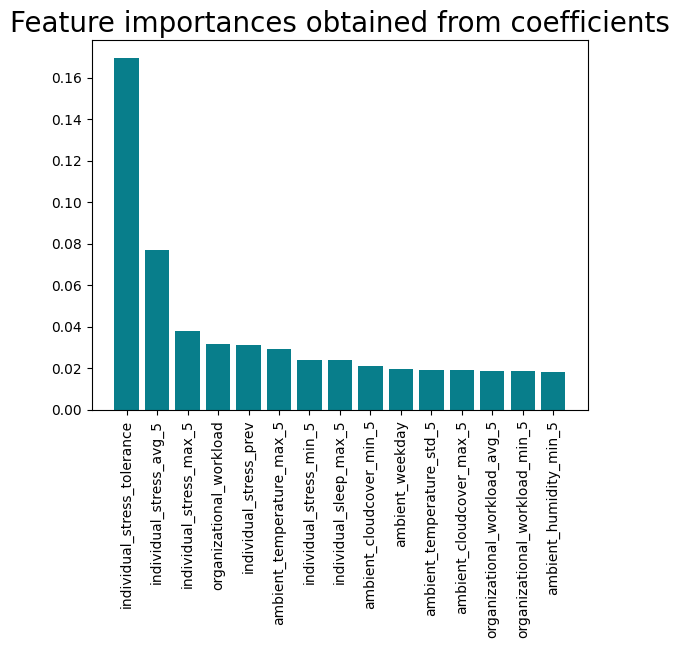

In [56]:
importances = pd.DataFrame(data={
    'Attribute': fbk_max_f1['feature_names'],
    'Importance': fbk_max_f1['feature_importances']
})

importances = importances.sort_values(by='Importance', ascending=False).head(15)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

([<matplotlib.patches.Wedge at 0x7fc6fc55c6a0>,
 [Text(-1.0176577034802021, -0.6359031361358436, 'Individual'),
  Text(0.84264892053104, -0.7070663312079519, 'Organizational'),
  Text(0.4120671763653917, 1.0199022708878795, 'Ambiental')],
 [Text(-0.5936336603634511, -0.3709434960792421, '40.0%'),
  Text(0.4596266839260218, -0.38567254429524644, '20.0%'),
  Text(0.22476391438112273, 0.5563103295752069, '40.0%')])

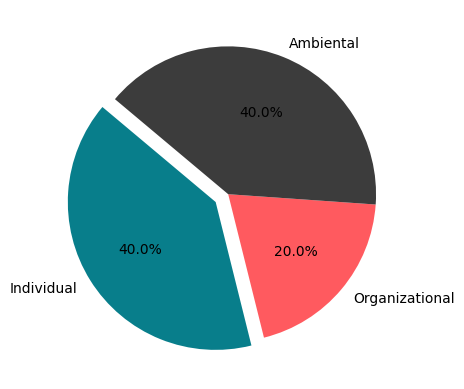

In [57]:
# count number of times each feature category appears in the top 20 features
top20_features = importances.Attribute.values.tolist()
individual_features_count = sum('individual' in s for s in top20_features)
organizational_features_count = sum('organizational' in s for s in top20_features)
ambiental_features_count = sum('ambient' in s for s in top20_features)

# plot pie chart
labels = ['Individual', 'Organizational', 'Ambiental']
sizes = [individual_features_count, organizational_features_count, ambiental_features_count]
colors = ['#087E8B', '#FF5A5F', '#3C3C3C']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=False, startangle=140)

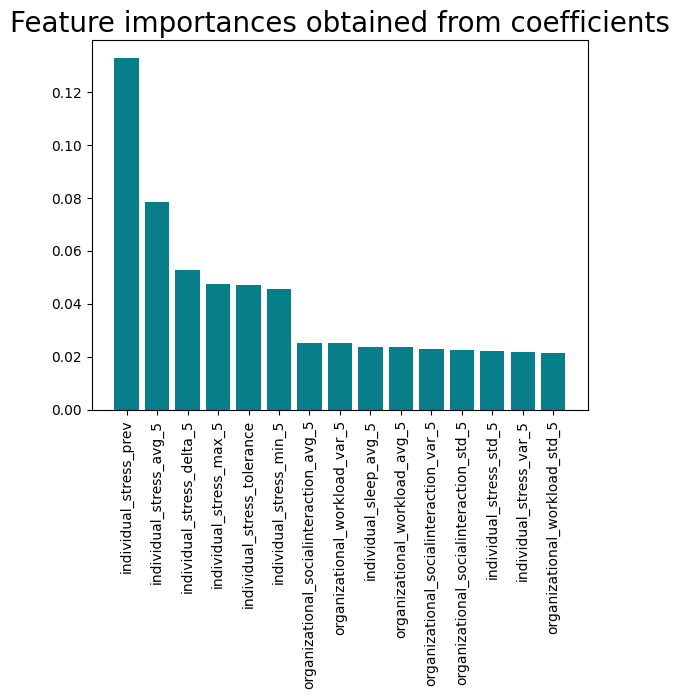

In [58]:
importances = pd.DataFrame(data={
    'Attribute': sl_max_f1['feature_names'],
    'Importance': sl_max_f1['feature_importances']
})

importances = importances.sort_values(by='Importance', ascending=False).head(15)
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

([<matplotlib.patches.Wedge at 0x7fc6a84c77c0>,
 [Text(-0.44952782876224534, -1.112620659150414, 'Individual'),
  Text(0.4120670808752478, 1.0199023094683883, 'Organizational'),
  Text(-0.8426490198315228, 0.7070662128662168, 'Ambiental')],
 [Text(-0.26222456677797645, -0.6490287178377414, '60.0%'),
  Text(0.22476386229558967, 0.5563103506191208, '40.0%'),
  Text(-0.4596267380899215, 0.38567247974520913, '0.0%')])

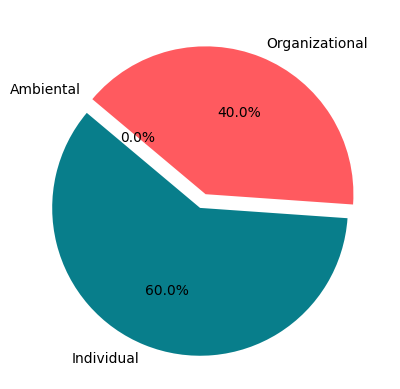

In [59]:
# count number of times each feature category appears in the top 20 features
top20sl_features = importances.Attribute.values.tolist()
individual_features_count = sum('individual' in s for s in top20sl_features)
organizational_features_count = sum('organizational' in s for s in top20sl_features)
ambiental_features_count = sum('ambient' in s for s in top20sl_features)

# plot pie chart
labels = ['Individual', 'Organizational', 'Ambiental']
sizes = [individual_features_count, organizational_features_count, ambiental_features_count]
colors = ['#087E8B', '#FF5A5F', '#3C3C3C']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
    autopct='%1.1f%%', shadow=False, startangle=140)